# **<span style="color:white;">US Dataset: Loading and Cleaning</span>**

## **Purpose of Notebook**
Preparing the raw data for EDA, merging datasets, clearning, dropping columns, filling blanks with 'missing', fixing formats etc

## **Contents of notebook**
### **Section X: **
```python 
- [x] Loading the datasets

```

---

**Import Necessary Libraries and Modules**

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

In [11]:

def load_and_preprocess_data(us_path, uk_path):
    """Load and preprocess AV datasets"""
    
    # Load data
    us_data = pd.read_csv(us_path)
    uk_data = pd.read_csv(uk_path)
    
    # Remove ID columns if they exist
    id_cols = ['Report ID', 'Report Version']
    for col in id_cols:
        if col in us_data.columns:
            us_data = us_data.drop(columns=[col])
        if col in uk_data.columns:
            uk_data = uk_data.drop(columns=[col])
    
    print(f"US Data: {us_data.shape[0]} incidents, {us_data.shape[1]} features")
    print(f"UK Data: {uk_data.shape[0]} incidents, {uk_data.shape[1]} features")
    
    return us_data, uk_data

In [12]:

def preprocess_dataset(df):
    """Simple preprocessing function"""
    df_clean = df.copy()
    
    # Handle missing values
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    # Encode categorical variables
    label_encoders = {}
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))
            label_encoders[col] = le
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean)
    
    return scaled_data, df_clean, list(df_clean.columns), scaler, label_encoders


In [13]:
# Load your data - UPDATE THESE PATHS
us_data, uk_data = load_and_preprocess_data('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_data.csv', '/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')

# Preprocess datasets
us_scaled, us_encoded, us_features, us_scaler, us_encoders = preprocess_dataset(us_data)
uk_scaled, uk_encoded, uk_features, uk_scaler, uk_encoders = preprocess_dataset(uk_data)

US Data: 4032 incidents, 19 features
UK Data: 229782 incidents, 21 features


In [14]:

def perform_grid_search(data, dataset_name):
    """Grid search for optimal clustering parameters"""
    
    print(f"\nPerforming grid search for {dataset_name}...")
    
    # Sample data if too large for grid search
    if len(data) > 5000:
        indices = np.random.choice(len(data), 5000, replace=False)
        search_data = data[indices]
    else:
        search_data = data
    
    best_params = {}
    
    # K-Means grid search
    print("- Optimizing K-Means...")
    kmeans_scores = []
    k_range = range(2, 11)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(search_data)
        score = silhouette_score(search_data, labels)
        kmeans_scores.append(score)
    
    best_k = k_range[np.argmax(kmeans_scores)]
    best_params['kmeans'] = {'n_clusters': best_k}
    print(f"  Best K-Means: k={best_k}, silhouette={max(kmeans_scores):.4f}")
    
    # DBSCAN grid search
    print("- Optimizing DBSCAN...")
    dbscan_scores = []
    eps_range = [0.3, 0.5, 0.7, 1.0, 1.5]
    min_samples_range = [10, 20, 30]
    best_dbscan_score = -1
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(search_data)
            
            if len(np.unique(labels)) > 1 and np.sum(labels != -1) > 10:
                valid_data = search_data[labels != -1]
                valid_labels = labels[labels != -1]
                if len(np.unique(valid_labels)) > 1:
                    score = silhouette_score(valid_data, valid_labels)
                    if score > best_dbscan_score:
                        best_dbscan_score = score
                        best_params['dbscan'] = {'eps': eps, 'min_samples': min_samples}
    
    if best_dbscan_score > -1:
        print(f"  Best DBSCAN: eps={best_params['dbscan']['eps']}, min_samples={best_params['dbscan']['min_samples']}, silhouette={best_dbscan_score:.4f}")
    else:
        best_params['dbscan'] = {'eps': 0.5, 'min_samples': 20}
        print("  DBSCAN: Using default parameters")
    
    return best_params

# Perform grid search for both datasets
us_best_params = perform_grid_search(us_scaled, "US Data")
uk_best_params = perform_grid_search(uk_scaled, "UK Data")



Performing grid search for US Data...
- Optimizing K-Means...
  Best K-Means: k=2, silhouette=0.2535
- Optimizing DBSCAN...
  Best DBSCAN: eps=0.7, min_samples=10, silhouette=0.6550

Performing grid search for UK Data...
- Optimizing K-Means...
  Best K-Means: k=4, silhouette=0.1198
- Optimizing DBSCAN...
  Best DBSCAN: eps=1.5, min_samples=10, silhouette=0.2825


In [15]:

def apply_clustering(data, best_params):
    """Apply clustering with optimal parameters"""
    
    results = {}
    
    # K-Means
    kmeans = KMeans(n_clusters=best_params['kmeans']['n_clusters'], random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(data)
    results['KMeans'] = kmeans_labels
    
    # DBSCAN
    dbscan = DBSCAN(eps=best_params['dbscan']['eps'], min_samples=best_params['dbscan']['min_samples'])
    dbscan_labels = dbscan.fit_predict(data)
    results['DBSCAN'] = dbscan_labels
    
    return results

# Apply clustering
us_clusters = apply_clustering(us_scaled, us_best_params)
uk_clusters = apply_clustering(uk_scaled, uk_best_params)


In [16]:
def cross_validate_clustering(data, method_params, cv_folds=5):
    """Cross-validation for clustering stability"""
    
    print("Running cross-validation for clustering stability...")
    
    # Sample data for CV if too large
    if len(data) > 3000:
        indices = np.random.choice(len(data), 3000, replace=False)
        cv_data = data[indices]
    else:
        cv_data = data
    
    cv_scores = {'KMeans': [], 'DBSCAN': []}
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    for train_idx, test_idx in kf.split(cv_data):
        train_data = cv_data[train_idx]
        test_data = cv_data[test_idx]
        
        # K-Means CV
        kmeans = KMeans(n_clusters=method_params['kmeans']['n_clusters'], random_state=42)
        kmeans.fit(train_data)
        test_labels = kmeans.predict(test_data)
        if len(np.unique(test_labels)) > 1:
            score = silhouette_score(test_data, test_labels)
            cv_scores['KMeans'].append(score)
        
        # DBSCAN CV
        dbscan = DBSCAN(eps=method_params['dbscan']['eps'], min_samples=method_params['dbscan']['min_samples'])
        test_labels = dbscan.fit_predict(test_data)
        if len(np.unique(test_labels)) > 1 and np.sum(test_labels != -1) > 5:
            valid_data = test_data[test_labels != -1]
            valid_labels = test_labels[test_labels != -1]
            if len(np.unique(valid_labels)) > 1:
                score = silhouette_score(valid_data, valid_labels)
                cv_scores['DBSCAN'].append(score)
    
    # Print CV results
    for method, scores in cv_scores.items():
        if scores:
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            print(f"{method} CV: {mean_score:.4f} ± {std_score:.4f}")
    
    return cv_scores

# Run cross-validation
print("\n--- US Data Cross-Validation ---")
us_cv_scores = cross_validate_clustering(us_scaled, us_best_params)

print("\n--- UK Data Cross-Validation ---")
uk_cv_scores = cross_validate_clustering(uk_scaled, uk_best_params)



--- US Data Cross-Validation ---
Running cross-validation for clustering stability...
KMeans CV: 0.2532 ± 0.0062

--- UK Data Cross-Validation ---
Running cross-validation for clustering stability...
KMeans CV: 0.1109 ± 0.0098


In [19]:
def evaluate_clustering(data, clusters_dict, dataset_name, sample_size=1000):
    """Evaluate clustering results with multiple metrics"""
    print(f"\n--- {dataset_name} Clustering Evaluation ---")

    results = []

    for method, labels in clusters_dict.items():
        # Handle noise points for DBSCAN
        if method == 'DBSCAN':
            valid_mask = labels != -1
            if np.sum(valid_mask) < 10 or len(np.unique(labels[valid_mask])) < 2:
                print(f"{method}: Not enough valid clusters")
                continue
            eval_data = data[valid_mask]
            eval_labels = labels[valid_mask]
        else:
            eval_data = data
            eval_labels = labels

        # Optionally sample to reduce evaluation time
        if sample_size and len(eval_data) > sample_size:
            sampled_indices = np.random.choice(len(eval_data), size=sample_size, replace=False)
            eval_data = eval_data[sampled_indices]
            eval_labels = eval_labels[sampled_indices]

        # Calculate metrics
        n_clusters = len(np.unique(eval_labels))
        n_noise = np.sum(labels == -1) if method == 'DBSCAN' else 0

        silhouette = silhouette_score(eval_data, eval_labels)
        calinski = calinski_harabasz_score(eval_data, eval_labels)
        davies = davies_bouldin_score(eval_data, eval_labels)

        result = {
            'Method': method,
            'N_Clusters': n_clusters,
            'N_Noise': n_noise,
            'Silhouette': silhouette,
            'Calinski_Harabasz': calinski,
            'Davies_Bouldin': davies
        }

        results.append(result)

        print(f"{method}:")
        print(f"  Clusters: {n_clusters}, Noise: {n_noise}")
        print(f"  Silhouette: {silhouette:.4f}")
        print(f"  Calinski-Harabasz: {calinski:.2f}")
        print(f"  Davies-Bouldin: {davies:.4f}")

    return pd.DataFrame(results)
us_evaluation = evaluate_clustering(us_scaled, us_clusters, "US Data", sample_size=4000)
uk_evaluation = evaluate_clustering(uk_scaled, uk_clusters, "UK Data", sample_size=3000)



--- US Data Clustering Evaluation ---
KMeans:
  Clusters: 2, Noise: 0
  Silhouette: 0.2534
  Calinski-Harabasz: 1450.94
  Davies-Bouldin: 1.5869
DBSCAN:
  Clusters: 6, Noise: 3943
  Silhouette: 0.6550
  Calinski-Harabasz: 404.83
  Davies-Bouldin: 0.5047

--- UK Data Clustering Evaluation ---
KMeans:
  Clusters: 4, Noise: 0
  Silhouette: 0.1164
  Calinski-Harabasz: 183.21
  Davies-Bouldin: 2.5236
DBSCAN:
  Clusters: 68, Noise: 116504
  Silhouette: -0.1413
  Calinski-Harabasz: 10.50
  Davies-Bouldin: 1.0286


Creating visualizations for US Data...


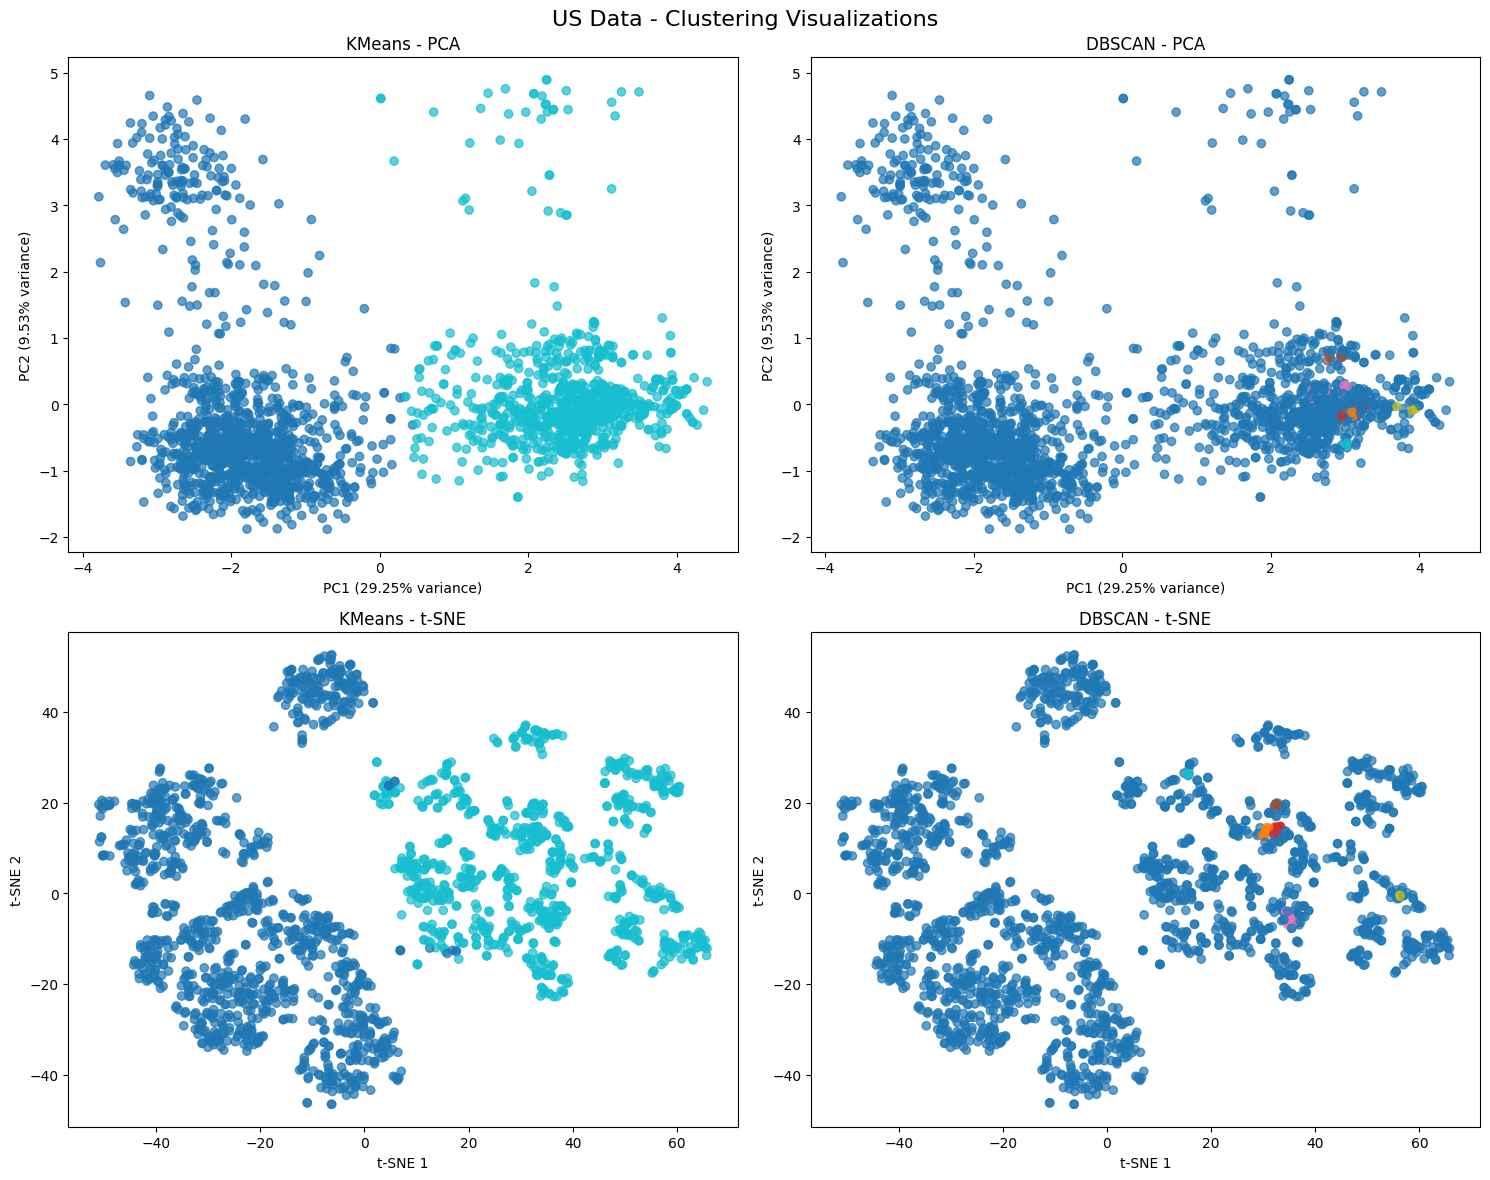

Creating visualizations for UK Data...


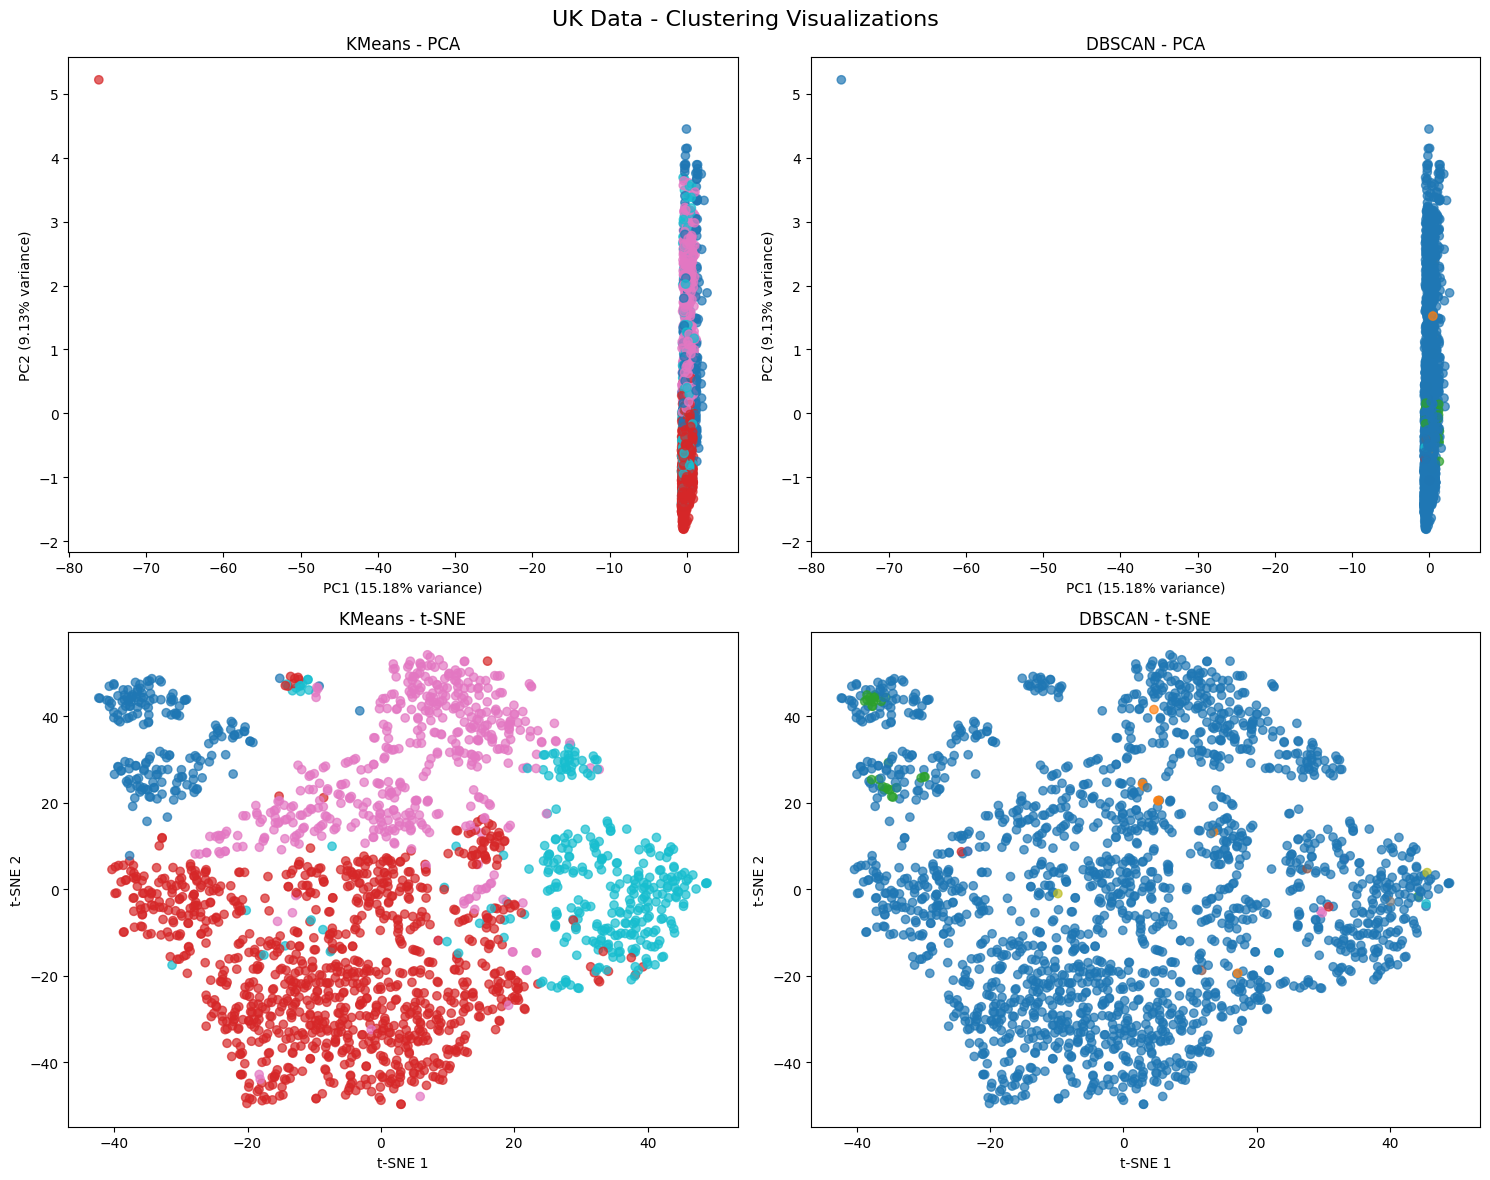

In [20]:
def create_clustering_visualizations(data, clusters_dict, dataset_name, feature_names):
    """Create t-SNE and PCA visualizations"""
    
    print(f"Creating visualizations for {dataset_name}...")
    
    # Sample data for visualization if too large
    if len(data) > 2000:
        indices = np.random.choice(len(data), 2000, replace=False)
        viz_data = data[indices]
        viz_clusters = {method: labels[indices] for method, labels in clusters_dict.items()}
    else:
        viz_data = data
        viz_clusters = clusters_dict
    
    # PCA
    pca = PCA(n_components=2, random_state=42)
    pca_data = pca.fit_transform(viz_data)
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_data = tsne.fit_transform(viz_data)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    methods = list(viz_clusters.keys())
    
    for i, method in enumerate(methods):
        labels = viz_clusters[method]
        
        # PCA plot
        scatter1 = axes[0, i].scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
        axes[0, i].set_title(f'{method} - PCA')
        axes[0, i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        axes[0, i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        
        # t-SNE plot
        scatter2 = axes[1, i].scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
        axes[1, i].set_title(f'{method} - t-SNE')
        axes[1, i].set_xlabel('t-SNE 1')
        axes[1, i].set_ylabel('t-SNE 2')
    
    plt.suptitle(f'{dataset_name} - Clustering Visualizations', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return pca, tsne

# Create visualizations
us_pca, us_tsne = create_clustering_visualizations(us_scaled, us_clusters, "US Data", us_features)
uk_pca, uk_tsne = create_clustering_visualizations(uk_scaled, uk_clusters, "UK Data", uk_features)



Best methods: US - DBSCAN, UK - KMeans
Running SHAP analysis for US Data - DBSCAN...


<Figure size 1000x800 with 0 Axes>

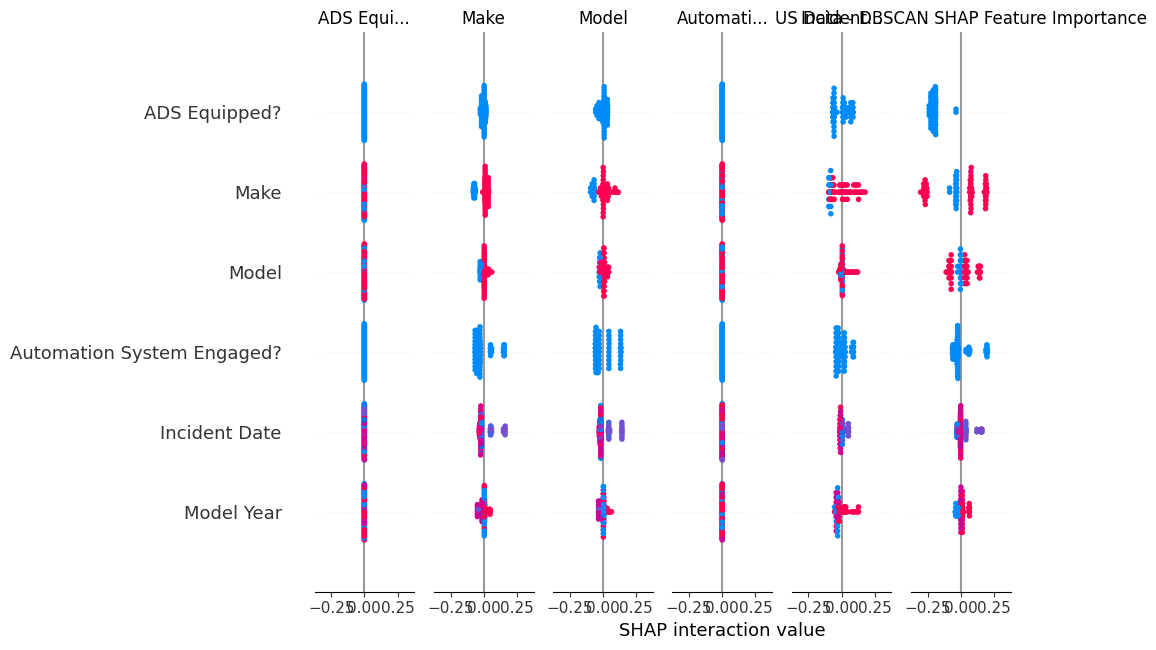

Running SHAP analysis for UK Data - KMeans...


<Figure size 1000x800 with 0 Axes>

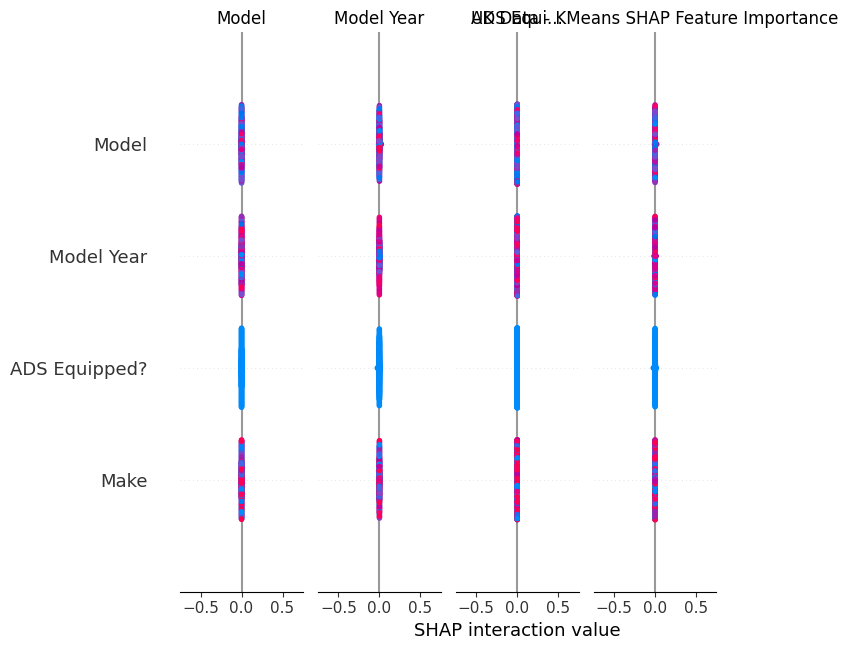

In [21]:

def apply_shap_analysis(data, labels, feature_names, dataset_name, method_name):
    """Apply SHAP for cluster explainability"""
    
    print(f"Running SHAP analysis for {dataset_name} - {method_name}...")
    
    # Handle noise points
    if method_name == 'DBSCAN':
        valid_mask = labels != -1
        if np.sum(valid_mask) < 50:
            print("Not enough valid samples for SHAP analysis")
            return None, None
        clean_data = data[valid_mask]
        clean_labels = labels[valid_mask]
    else:
        clean_data = data
        clean_labels = labels
    
    if len(np.unique(clean_labels)) < 2:
        print("Not enough clusters for SHAP analysis")
        return None, None
    
    # Train Random Forest classifier to predict clusters
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    rf.fit(clean_data, clean_labels)
    
    # SHAP analysis
    # Sample data for SHAP if too large
    if len(clean_data) > 500:
        shap_indices = np.random.choice(len(clean_data), 500, replace=False)
        shap_data = clean_data[shap_indices]
    else:
        shap_data = clean_data
    
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(shap_data)
    
    # Feature importance plot
    plt.figure(figsize=(10, 8))
    if len(shap_values) > 2:  # Multi-class
        shap.summary_plot(shap_values, shap_data, feature_names=feature_names, 
                         class_names=[f'Cluster {i}' for i in range(len(shap_values))], show=False)
    else:  # Binary
        shap.summary_plot(shap_values[1] if isinstance(shap_values, list) else shap_values, 
                         shap_data, feature_names=feature_names, show=False)
    
    plt.title(f'{dataset_name} - {method_name} SHAP Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return rf, shap_values

# Apply SHAP analysis for best performing methods
def get_best_method(evaluation_df):
    """Get best method based on silhouette score"""
    if evaluation_df is not None and len(evaluation_df) > 0:
        best_idx = evaluation_df['Silhouette'].idxmax()
        return evaluation_df.loc[best_idx, 'Method']
    return 'KMeans'  # Default

# Get best methods
us_best_method = get_best_method(us_evaluation)
uk_best_method = get_best_method(uk_evaluation)

print(f"\nBest methods: US - {us_best_method}, UK - {uk_best_method}")

# Apply SHAP
us_rf, us_shap = apply_shap_analysis(us_scaled, us_clusters[us_best_method], us_features, 
                                    "US Data", us_best_method)
uk_rf, uk_shap = apply_shap_analysis(uk_scaled, uk_clusters[uk_best_method], uk_features, 
                                    "UK Data", uk_best_method)


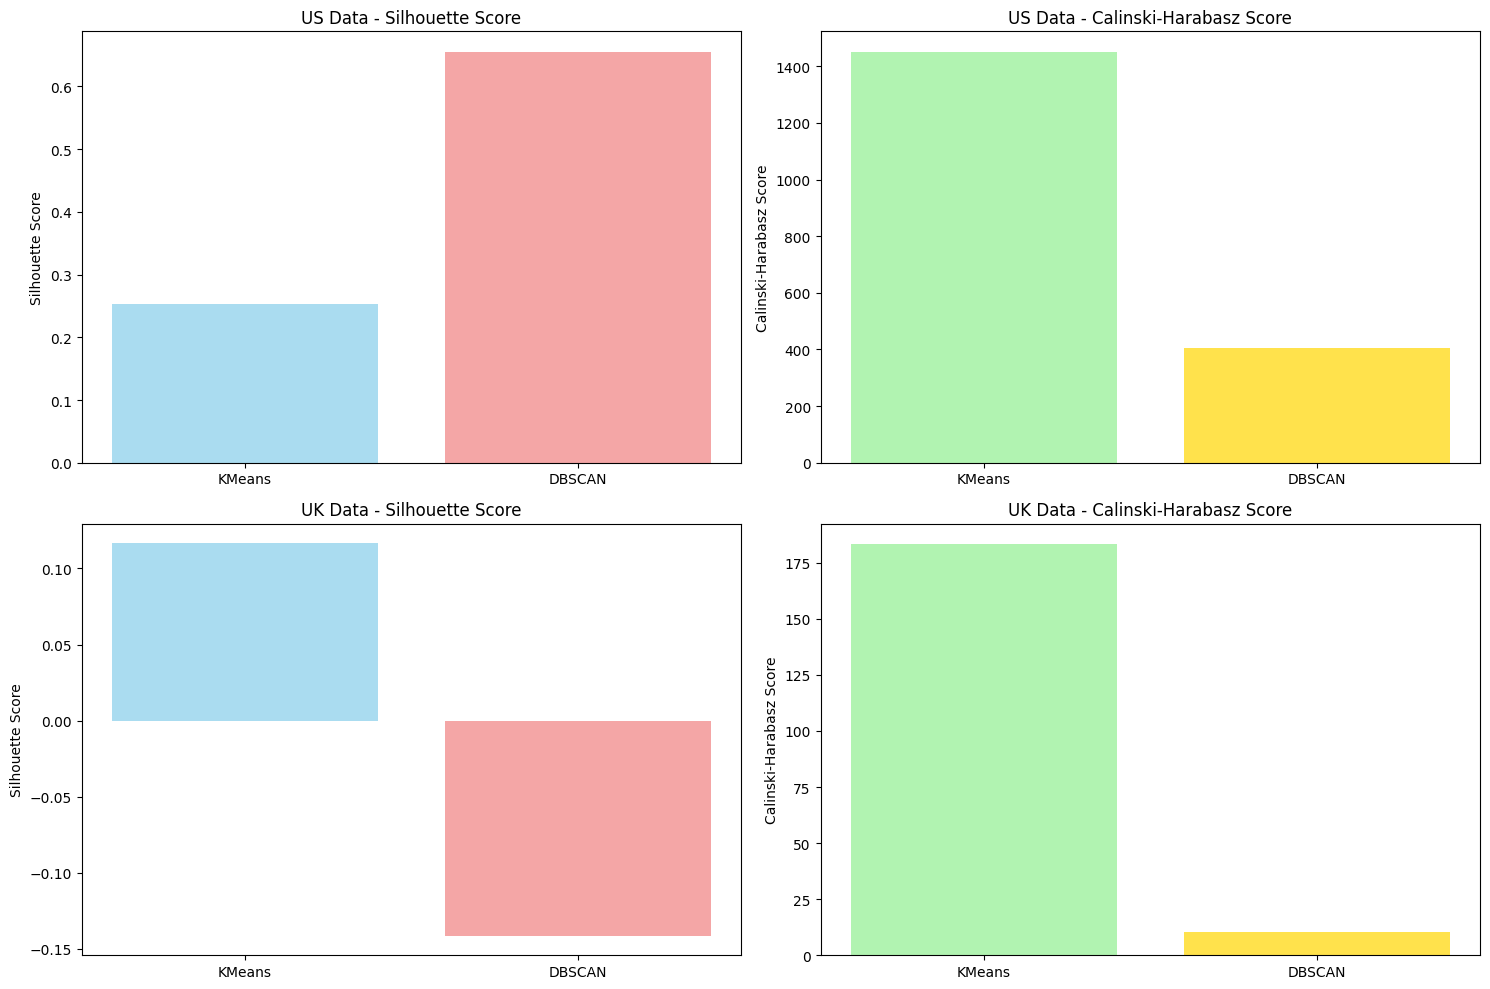

In [22]:
def create_performance_comparison():
    """Create simple performance comparison charts"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # US Data metrics
    if us_evaluation is not None and len(us_evaluation) > 0:
        methods = us_evaluation['Method']
        silhouette = us_evaluation['Silhouette']
        calinski = us_evaluation['Calinski_Harabasz']
        
        axes[0,0].bar(methods, silhouette, alpha=0.7, color=['skyblue', 'lightcoral'])
        axes[0,0].set_title('US Data - Silhouette Score')
        axes[0,0].set_ylabel('Silhouette Score')
        
        axes[0,1].bar(methods, calinski, alpha=0.7, color=['lightgreen', 'gold'])
        axes[0,1].set_title('US Data - Calinski-Harabasz Score')
        axes[0,1].set_ylabel('Calinski-Harabasz Score')
    
    # UK Data metrics
    if uk_evaluation is not None and len(uk_evaluation) > 0:
        methods = uk_evaluation['Method']
        silhouette = uk_evaluation['Silhouette']
        calinski = uk_evaluation['Calinski_Harabasz']
        
        axes[1,0].bar(methods, silhouette, alpha=0.7, color=['skyblue', 'lightcoral'])
        axes[1,0].set_title('UK Data - Silhouette Score')
        axes[1,0].set_ylabel('Silhouette Score')
        
        axes[1,1].bar(methods, calinski, alpha=0.7, color=['lightgreen', 'gold'])
        axes[1,1].set_title('UK Data - Calinski-Harabasz Score')
        axes[1,1].set_ylabel('Calinski-Harabasz Score')
    
    plt.tight_layout()
    plt.show()

create_performance_comparison()


In [23]:

def print_summary_results():
    """Print final summary"""
    
    print("\n" + "="*60)
    print("CLUSTERING ANALYSIS SUMMARY")
    print("="*60)
    
    print("\nUS DATA RESULTS:")
    if us_evaluation is not None and len(us_evaluation) > 0:
        best_us = us_evaluation.loc[us_evaluation['Silhouette'].idxmax()]
        print(f"Best Method: {best_us['Method']}")
        print(f"Silhouette Score: {best_us['Silhouette']:.4f}")
        print(f"Number of Clusters: {best_us['N_Clusters']}")
        print(f"Optimal K-Means K: {us_best_params['kmeans']['n_clusters']}")
    
    print("\nUK DATA RESULTS:")
    if uk_evaluation is not None and len(uk_evaluation) > 0:
        best_uk = uk_evaluation.loc[uk_evaluation['Silhouette'].idxmax()]
        print(f"Best Method: {best_uk['Method']}")
        print(f"Silhouette Score: {best_uk['Silhouette']:.4f}")
        print(f"Number of Clusters: {best_uk['N_Clusters']}")
        print(f"Optimal K-Means K: {uk_best_params['kmeans']['n_clusters']}")
    
    print("\nCROSS-VALIDATION STABILITY:")
    print("US Data:")
    for method, scores in us_cv_scores.items():
        if scores:
            print(f"  {method}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    print("UK Data:")
    for method, scores in uk_cv_scores.items():
        if scores:
            print(f"  {method}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)

print_summary_results()

# Export results
if us_evaluation is not None:
    us_evaluation.to_csv('us_clustering_results.csv', index=False)
if uk_evaluation is not None:
    uk_evaluation.to_csv('uk_clustering_results.csv', index=False)

print("\nResults exported to CSV files.")
print("Analysis complete! Check the visualizations and printed results above.")


CLUSTERING ANALYSIS SUMMARY

US DATA RESULTS:
Best Method: DBSCAN
Silhouette Score: 0.6550
Number of Clusters: 6
Optimal K-Means K: 2

UK DATA RESULTS:
Best Method: KMeans
Silhouette Score: 0.1164
Number of Clusters: 4
Optimal K-Means K: 4

CROSS-VALIDATION STABILITY:
US Data:
  KMeans: 0.2532 ± 0.0062
UK Data:
  KMeans: 0.1109 ± 0.0098

ANALYSIS COMPLETE

Results exported to CSV files.
Analysis complete! Check the visualizations and printed results above.
